# Movie Recommendation System

### Abstract

In this notebook we are trying to implement a Movie Recommendation System for which we have used Movielens dataset. It is a  research is about implementing different algorithms on Movielens dataset and recommending movies to users. Different filtering techniques have been incorporated initially to check how well they perform on the dataset. Collaborative filtering being one of the most widely used technique for recommendation systems is implemented here. These techniques have their own drawbacks which is the purpose of this research project. We have implemented various functions which takes corresponding inputs to determine which movies to recommend against that input.

<img src="1.jpeg" alt="Drawing" style="width: 100%;"/>

### Dataset Description

This notebook uses 3 CSV files i.e. for users, movies and ratings. There are approximately 6040 users and 3705 movies. The ratings file has corresponding ratings of users for particular movie. The data fields in respective files are as follows:<br>
<h3> Users:</h3><br>
<ul>
    <li><strong>user_id:</strong>  Id for user</li>
<li><strong>gender:</strong>   Gender of user</li>
<li><strong>age:</strong>   Age of user</li>
<li><strong>occupation:</strong>   Occupation of user</li>
<li><strong>zipcode:</strong>   Zipcode of user</li>
<li><strong>age_desc:</strong> Describe the class of age group</li>
<li><strong>occ_desc:</strong>   Describe the class of occupation</li>
</ul>
<h3> Movies:</h3><br>
<ul>
<li><strong>movie_id:</strong>Id for movie</li>
<li><strong>title:</strong> Movie Title</li>
<li><strong>genres:</strong>Genres in which movie can be categorized</li>
</ul>
<h3> Ratings:</h3><br>
<ul>
<li><strong>user_id:</strong>Id for user</li>
<li><strong>movie_id:</strong>Id for movie</li>
<li><strong>rating:</strong>Ratings given by that user to that movie</li>
<li><strong>timestamp:</strong>Timestamp when booking was done</li>

</ul>

In [6]:
# importing libraries
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from sklearn import metrics
import gc
import statsmodels.api as sm
from sklearn import linear_model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.metrics import mean_squared_error,accuracy_score, r2_score, make_scorer,log_loss
from sklearn.model_selection import KFold


Reading CSV files

In [7]:
df_ratings = pd.read_csv('Dataset/ratings.csv', sep='\t', encoding='latin-1', usecols=['user_id','movie_id','rating','timestamp'])
df_movies = pd.read_csv('Dataset/movies.csv', sep='\t', encoding='latin-1', usecols=['movie_id','title','genres'])
df_users = pd.read_csv('Dataset/users.csv', sep='\t', encoding='latin-1',  usecols=['user_id','gender','age','occupation','zipcode','age_desc','occ_desc'])

In [72]:
##  EDA for users

In [73]:
df_users.head()

,user_id,gender,age,occupation,zipcode,age_desc,occ_desc
0,1,F,1,10,48067,Under 18,K-12 student
1,2,M,56,16,70072,56+,self-employed
2,3,M,25,15,55117,25-34,scientist
3,4,M,45,7,02460,45-49,executive/managerial
4,5,M,25,20,55455,25-34,writer


Number of ratings by male and female

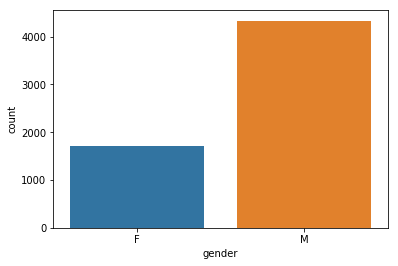

In [74]:
sns.countplot(df_users['gender'])

Number of ratings according to age

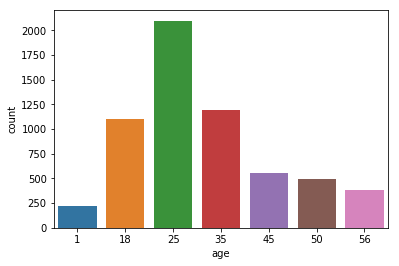

In [75]:
sns.countplot(df_users['age'])

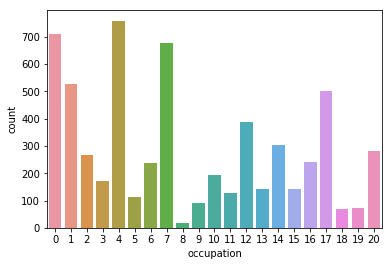

In [76]:
sns.countplot(df_users['occupation'])

From above count plot it can be concluded that age and gender could be important estimators as they are able to determine the distribution of ratings properly.

## EDA for movies

In [77]:
df_movies.head(30)

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children's
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


Determining the popularity on genres based on number of movies belonging to same genre. The below function calculates the number of movies for each genre.

In [78]:
# Make a census of the genre keywords
genre_labels = set()
for s in df_movies['genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))

# Function that counts the number of times each of the genre keywords appear
def count_word(dataset, ref_col, census):
    keyword_count = dict()
    for s in census: 
        keyword_count[s] = 0
    for census_keywords in dataset[ref_col].str.split('|'):        
        if type(census_keywords) == float and pd.isnull(census_keywords): 
            continue        
        for s in [s for s in census_keywords if s in census]: 
            if pd.notnull(s): 
                keyword_count[s] += 1
    #______________________________________________________________________
    # convert the dictionary in a list to sort the keywords by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

# Calling this function gives access to a list of genre keywords which are sorted by decreasing frequency
keyword_occurences, dum = count_word(df_movies, 'genres', genre_labels)
keyword_occurences[:]

[['Drama', 1603],
 ['Comedy', 1200],
 ['Action', 503],
 ['Thriller', 492],
 ['Romance', 471],
 ['Horror', 343],
 ['Adventure', 283],
 ['Sci-Fi', 276],
 ["Children's", 251],
 ['Crime', 211],
 ['War', 143],
 ['Documentary', 127],
 ['Musical', 114],
 ['Mystery', 106],
 ['Animation', 105],
 ['Fantasy', 68],
 ['Western', 68],
 ['Film-Noir', 44]]

Spliting the genres separated by '|'

In [34]:
array=[]
array= df_movies['genres'].str.split('|')
df_movies['genres'] =array

In [79]:
df_movies.isnull().values.any()

False

In [80]:
df_ratings.isnull().values.any()

False

/Users/sarthakgoel/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


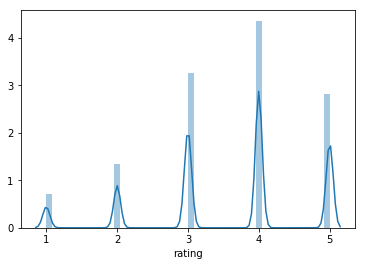

In [81]:
sns.distplot(df_ratings["rating"]);

The average ratings seem to be more generous as most of the ratings are 4.0

Merging all dataframes

In [8]:
dataset = pd.merge(pd.merge(df_movies, df_ratings),df_users)

In [83]:
dataset.head()

,movie_id,title,genres,user_id,rating,timestamp,gender,age,occupation,zipcode,age_desc,occ_desc
0,1,Toy Story (1995),Animation|Children's|Comedy,1,5,978824268,F,1,10,48067,Under 18,K-12 student
1,48,Pocahontas (1995),Animation|Children's|Musical|Romance,1,5,978824351,F,1,10,48067,Under 18,K-12 student
2,150,Apollo 13 (1995),Drama,1,5,978301777,F,1,10,48067,Under 18,K-12 student
3,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi,1,4,978300760,F,1,10,48067,Under 18,K-12 student
4,527,Schindler's List (1993),Drama|War,1,5,978824195,F,1,10,48067,Under 18,K-12 student


# Content based filtering
<hr>

Content-based filtering, also referred to as cognitive filtering, recommends items based on a comparison between the content of the items and a user profile. The content of each item is represented as a set of descriptors or terms, typically the words that occur in a document. The user profile is represented with the same terms and built up by analyzing the content of items which have been seen by the user. A content based recommender works with data that the user provides, either explicitly (rating) or implicitly (clicking on a link). Based on that data, a user profile is generated, which is then used to make suggestions to the user. As the user provides more inputs or takes actions on the recommendations, the engine becomes more and more accurate.

The concepts of Term Frequency (TF) and Inverse Document Frequency (IDF) are used in information retrieval systems and also content based filtering mechanisms (such as a content based recommender). They are used to determine the relative importance of a document / article / news item / movie etc

<h3>Term Frequency (TF) and Inverse Document Frequency (IDF)</h3><br>
TF is simply the frequency of a word in a document. IDF is the inverse of the document frequency among the whole corpus of documents. TF-IDF is used mainly because of two reasons: Suppose we search for “the rise of analytics” on Google. It is certain that “the” will occur more frequently than “analytics” but the relative importance of analytics is higher than the search query point of view. In such cases, TF-IDF weighting negates the effect of high frequency words in determining the importance of an item (document).


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(df_movies['genres'])
tfidf_matrix.shape

(3883, 127)

For finding similarity between the vectors we would be using Cosine Similarity. Cosine similarity calculates similarity by measuring the cosine of angle between two vectors. With cosine similarity, we would find the similarity values for each movie and represent them in form of matrix. Currently we are using linear_kernel for finding cosine similarity.

<img src="2.jpeg" alt="Drawing" style="width: 800px;"/>

In [10]:
from sklearn.metrics.pairwise import linear_kernel
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim[:4, :4]

array([[1.        , 0.14193614, 0.09010857, 0.1056164 ],
       [0.14193614, 1.        , 0.        , 0.        ],
       [0.09010857, 0.        , 1.        , 0.1719888 ],
       [0.1056164 , 0.        , 0.1719888 , 1.        ]])

The below function takes movie name as input, then we find the corresponding movie_id and then find similar scores of other movies with respect to that movie. Once we have values for similarity, sort it in descending order, and get the top similar fovies for recommendation

In [11]:
titles = df_movies['title']
indices = pd.Series(df_movies.index, index=df_movies['title'])
def genre_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:21]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [12]:
genre_recommendations('Good Will Hunting (1997)').head(20)

25                                        Othello (1995)
26                                   Now and Then (1995)
29     Shanghai Triad (Yao a yao yao dao waipo qiao) ...
30                                Dangerous Minds (1995)
35                               Dead Man Walking (1995)
39                       Cry, the Beloved Country (1995)
42                                    Restoration (1995)
52                                       Lamerica (1994)
54                                        Georgia (1995)
56                          Home for the Holidays (1995)
61                             Mr. Holland's Opus (1995)
66                                       Two Bits (1995)
77                            Crossing Guard, The (1995)
79          White Balloon, The (Badkonake Sefid ) (1995)
81                       Antonia's Line (Antonia) (1995)
82       Once Upon a Time... When We Were Colored (1995)
89                    Journey of August King, The (1995)
92                             

# Collaborative Filtering
<hr>

Collaborative filtering (CF) is a technique commonly used to build personalized recommendations on the Web. Some popular websites that make use of the collaborative filtering technology include Amazon, Netflix, iTunes, IMDB, LastFM, Delicious and StumbleUpon. In collaborative filtering, algorithms are used to make automatic predictions about a user's interests by compiling preferences from several users. 

For example, a site like Amazon may recommend that the customers who purchase books A and B purchase book C as well. This is done by comparing the historical preferences of those who have purchased the same books.

Different types of collaborative filtering are as follows:<br>
<ul>
<li>Memory Based: This method makes use of user rating information to calculate the likeness between the users or items. This calculated likeness is then used to make recommendations.</li><br>
<li>Model Based: Models are created by using data mining, and the system learns algorithms to look for habits according to training data. These models are then used to come up with predictions for actual data.</li><br>
    <li>Hybrid: Various programs combine the model-based and memory-based CF algorithms.</li></ul>

In [13]:
dataset.head(10)

,movie_id,title,genres,user_id,rating,timestamp,gender,age,occupation,zipcode,age_desc,occ_desc
0,1,Toy Story (1995),Animation|Children's|Comedy,1,5,978824268,F,1,10,48067,Under 18,K-12 student
1,48,Pocahontas (1995),Animation|Children's|Musical|Romance,1,5,978824351,F,1,10,48067,Under 18,K-12 student
2,150,Apollo 13 (1995),Drama,1,5,978301777,F,1,10,48067,Under 18,K-12 student
3,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi,1,4,978300760,F,1,10,48067,Under 18,K-12 student
4,527,Schindler's List (1993),Drama|War,1,5,978824195,F,1,10,48067,Under 18,K-12 student
5,531,"Secret Garden, The (1993)",Children's|Drama,1,4,978302149,F,1,10,48067,Under 18,K-12 student
6,588,Aladdin (1992),Animation|Children's|Comedy|Musical,1,4,978824268,F,1,10,48067,Under 18,K-12 student
7,594,Snow White and the Seven Dwarfs (1937),Animation|Children's|Musical,1,4,978302268,F,1,10,48067,Under 18,K-12 student
8,595,Beauty and the Beast (1991),Animation|Children's|Musical,1,5,978824268,F,1,10,48067,Under 18,K-12 student
9,608,Fargo (1996),Crime|Drama|Thriller,1,4,978301398,F,1,10,48067,Under 18,K-12 student


Finding the null values in user_id and movie_id and replacing it with 0. Null values in ratings are replaced by average values.

In [14]:
df_ratings['user_id'] = df_ratings['user_id'].fillna(0)
df_ratings['movie_id'] = df_ratings['movie_id'].fillna(0)
 

In [15]:
print(dataset.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000209 entries, 0 to 1000208
Data columns (total 12 columns):
movie_id      1000209 non-null int64
title         1000209 non-null object
genres        1000209 non-null object
user_id       1000209 non-null int64
rating        1000209 non-null int64
timestamp     1000209 non-null int64
gender        1000209 non-null object
age           1000209 non-null int64
occupation    1000209 non-null int64
zipcode       1000209 non-null object
age_desc      1000209 non-null object
occ_desc      1000209 non-null object
dtypes: int64(6), object(6)
memory usage: 99.2+ MB
None


This dataset is very huge, our system might run out of memory while performing further computations. So we will perform out operatons on small fraction of dataset

In [16]:
small_data = df_ratings.sample(frac=0.02)
print(small_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20004 entries, 77983 to 889044
Data columns (total 4 columns):
user_id      20004 non-null int64
movie_id     20004 non-null int64
rating       20004 non-null int64
timestamp    20004 non-null int64
dtypes: int64(4)
memory usage: 781.4 KB
None


## Item-Item Colaborative Filtering
<hr>

<img src="4.jpeg" alt="Drawing" style="width: 800px;"/>

In [17]:
ratings_matrix_items = dataset.pivot_table(index=['movie_id'],columns=['user_id'],values='rating').reset_index(drop=True)
ratings_matrix_items.fillna( 0, inplace = True )
ratings_matrix_items.shape


(3706, 6040)

In [18]:
ratings_matrix_items

user_id,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
0,5.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,5.0,5.0,...,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,3.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,2.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The ratings_matrix_items holds the ratings for movies by users in form of matrix
Here we are using pairwise_distances to calculate how different every movie is using cosine metric. This difference is subtracted from '1' to get their value for similarity. We are filling the diagonal values with 0 as originally its value is '1' and it should not be returned when we want the value with highest similarity.

In [19]:
from sklearn.metrics.pairwise import pairwise_distances
movie_similarity = 1 - pairwise_distances( ratings_matrix_items.as_matrix(), metric="cosine" )
np.fill_diagonal( movie_similarity, 0 ) 
ratings_matrix_items = pd.DataFrame( movie_similarity )
ratings_matrix_items

/Users/sarthakgoel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


,0,1,2,3,4,5,6,7,8,9,...,3696,3697,3698,3699,3700,3701,3702,3703,3704,3705
0,0.000000,0.390349,0.267943,0.178789,0.256569,0.347373,0.301490,0.125709,0.106620,0.377459,...,0.099502,0.020966,0.084105,0.081826,0.045949,0.309676,0.186633,0.093479,0.042829,0.182691
1,0.390349,0.000000,0.240946,0.155457,0.249970,0.244827,0.262772,0.196521,0.158469,0.386200,...,0.061819,0.015209,0.075310,0.095573,0.074271,0.213650,0.140781,0.087013,0.026063,0.122185
2,0.267943,0.240946,0.000000,0.192788,0.308290,0.187020,0.292230,0.092122,0.128378,0.245601,...,0.038492,0.065507,0.049512,0.087377,0.050985,0.190575,0.104837,0.062258,0.010073,0.097786
3,0.178789,0.155457,0.192788,0.000000,0.271990,0.125170,0.220024,0.049554,0.060334,0.133707,...,0.055486,0.053300,0.002227,0.025278,0.025204,0.118902,0.096318,0.022588,0.024769,0.095154
4,0.256569,0.249970,0.308290,0.271990,0.000000,0.148114,0.305107,0.095512,0.138392,0.237681,...,0.026632,0.083898,0.046399,0.047542,0.016156,0.174554,0.092403,0.051633,0.010750,0.112835
5,0.347373,0.244827,0.187020,0.125170,0.148114,0.000000,0.184966,0.055532,0.172145,0.418485,...,0.089106,0.025354,0.017274,0.112076,0.087213,0.236447,0.201419,0.115331,0.029136,0.222836
6,0.301490,0.262772,0.292230,0.220024,0.305107,0.184966,0.000000,0.049023,0.083145,0.248029,...,0.066875,0.051497,0.037842,0.065268,0.051835,0.191689,0.117660,0.059262,0.036102,0.138879
7,0.125709,0.196521,0.092122,0.049554,0.095512,0.055532,0.049023,0.000000,0.045263,0.107235,...,0.028519,0.072446,0.064868,0.059819,0.066350,0.090387,0.080523,0.084976,0.072141,0.045523
8,0.106620,0.158469,0.128378,0.060334,0.138392,0.172145,0.083145,0.045263,0.000000,0.216823,...,0.046188,0.014033,0.020523,0.103986,0.049767,0.092347,0.099554,0.004956,0.000000,0.057881
9,0.377459,0.386200,0.245601,0.133707,0.237681,0.418485,0.248029,0.107235,0.216823,0.000000,...,0.072576,0.049577,0.041950,0.121969,0.090955,0.237227,0.136374,0.097170,0.018359,0.161396


The below function takes movie name as input and appends the value of similarity with that movie to 'df_movies'

In [20]:
def SimilarItems(movieName): 
    try:
        user_inp=movieName
        inp=df_movies[df_movies['title']==user_inp].index.tolist()
        inp=inp[0]
        df_movies['similarity'] = ratings_matrix_items.iloc[inp]
        df_movies.columns = ['movie_id', 'title', 'release_date','similarity']
    except:
        print("Movie not there")

The following function first forms a list of movies which user has already watched and has rated 4.5 or 5 i.e. 'user_movie'. Then it sorts the df_movie according to values of similarity and then select ratings with similarity value more than 0.45. Then a new dataframe 'df_recommended_item' is created to which we will append only those movies which have high similarity values but the user hasnt seen.

In [24]:
def recommendedMovies_ItemSimilarity(user_id):
    user_movie= dataset[(dataset.user_id==user_id) & dataset.rating.isin([5,4.5])][['title']]
    user_movie=user_movie.iloc[0,0]
    SimilarItems(user_movie)
    sorted_movies_as_per_userChoice=df_movies.sort_values( ["similarity"], ascending = False )
    sorted_movies_as_per_userChoice=sorted_movies_as_per_userChoice[sorted_movies_as_per_userChoice['similarity'] >=0.45]['movie_id']
    recommended_movies=list()
    df_recommended_item=pd.DataFrame()
    best10= pd.DataFrame()
    user2Movies= df_ratings[df_ratings['user_id']== user_id]['movie_id']
    for movieId in sorted_movies_as_per_userChoice:
            if movieId not in user2Movies:
                df_new= df_ratings[(df_ratings.movie_id==movieId)]
                df_recommended_item=pd.concat([df_recommended_item,df_new])
            best10=df_recommended_item.sort_values(["rating"], ascending = False )[1:10] 
    return best10['movie_id']

In [27]:
def getTitle(listMovieIDs):
    movie_titles= list()
    for id in listMovieIDs:
        movie_titles.append(df_movies[df_movies['movie_id']==id]['title'])
    return movie_titles

In [93]:
print("Movies to recommend,:\n",getTitle(recommendedMovies_ItemSimilarity(2)))

Movies to recommend,:
 [329    Tommy Boy (1995)
Name: title, dtype: object, 329    Tommy Boy (1995)
Name: title, dtype: object, 329    Tommy Boy (1995)
Name: title, dtype: object, 329    Tommy Boy (1995)
Name: title, dtype: object, 329    Tommy Boy (1995)
Name: title, dtype: object, 329    Tommy Boy (1995)
Name: title, dtype: object, 329    Tommy Boy (1995)
Name: title, dtype: object, 329    Tommy Boy (1995)
Name: title, dtype: object, 329    Tommy Boy (1995)
Name: title, dtype: object]


## User-Item Colaborative filtering

<img src="3.jpeg" alt="Drawing" style="width: 800px;"/>

In the user-based approach the algorithm produces a rating for an item i by a user u by combining the ratings of other users u' that are similar to u. Similar here means that the two user's ratings have a high Pearson correlation or cosine similarity or something similar.

In [29]:
ratings_matrix_items = dataset.pivot_table(index=['movie_id'],columns=['user_id'],values='rating').reset_index(drop=True)
ratings_matrix_items.fillna( 0, inplace = True )
ratings_matrix_items.shape


(3706, 6040)

In [30]:
ratings_matrix_items

user_id,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
0,5.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,5.0,5.0,...,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,3.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,2.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


As done previously, we will find user_similarity

In [31]:
user_similarity = 1 - pairwise_distances( ratings_matrix_items.as_matrix(), metric="cosine" )
np.fill_diagonal( user_similarity, 0 )
ratings_matrix_user = pd.DataFrame( user_similarity )
ratings_matrix_user

/Users/sarthakgoel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


,0,1,2,3,4,5,6,7,8,9,...,3696,3697,3698,3699,3700,3701,3702,3703,3704,3705
0,0.000000,0.390349,0.267943,0.178789,0.256569,0.347373,0.301490,0.125709,0.106620,0.377459,...,0.099502,0.020966,0.084105,0.081826,0.045949,0.309676,0.186633,0.093479,0.042829,0.182691
1,0.390349,0.000000,0.240946,0.155457,0.249970,0.244827,0.262772,0.196521,0.158469,0.386200,...,0.061819,0.015209,0.075310,0.095573,0.074271,0.213650,0.140781,0.087013,0.026063,0.122185
2,0.267943,0.240946,0.000000,0.192788,0.308290,0.187020,0.292230,0.092122,0.128378,0.245601,...,0.038492,0.065507,0.049512,0.087377,0.050985,0.190575,0.104837,0.062258,0.010073,0.097786
3,0.178789,0.155457,0.192788,0.000000,0.271990,0.125170,0.220024,0.049554,0.060334,0.133707,...,0.055486,0.053300,0.002227,0.025278,0.025204,0.118902,0.096318,0.022588,0.024769,0.095154
4,0.256569,0.249970,0.308290,0.271990,0.000000,0.148114,0.305107,0.095512,0.138392,0.237681,...,0.026632,0.083898,0.046399,0.047542,0.016156,0.174554,0.092403,0.051633,0.010750,0.112835
5,0.347373,0.244827,0.187020,0.125170,0.148114,0.000000,0.184966,0.055532,0.172145,0.418485,...,0.089106,0.025354,0.017274,0.112076,0.087213,0.236447,0.201419,0.115331,0.029136,0.222836
6,0.301490,0.262772,0.292230,0.220024,0.305107,0.184966,0.000000,0.049023,0.083145,0.248029,...,0.066875,0.051497,0.037842,0.065268,0.051835,0.191689,0.117660,0.059262,0.036102,0.138879
7,0.125709,0.196521,0.092122,0.049554,0.095512,0.055532,0.049023,0.000000,0.045263,0.107235,...,0.028519,0.072446,0.064868,0.059819,0.066350,0.090387,0.080523,0.084976,0.072141,0.045523
8,0.106620,0.158469,0.128378,0.060334,0.138392,0.172145,0.083145,0.045263,0.000000,0.216823,...,0.046188,0.014033,0.020523,0.103986,0.049767,0.092347,0.099554,0.004956,0.000000,0.057881
9,0.377459,0.386200,0.245601,0.133707,0.237681,0.418485,0.248029,0.107235,0.216823,0.000000,...,0.072576,0.049577,0.041950,0.121969,0.090955,0.237227,0.136374,0.097170,0.018359,0.161396


In [32]:
ratings_matrix_user.idxmax(axis=1).sample( 10 )

2476    2378
3100    3075
649     1292
1605     821
1034     556
588      535
2488    2785
425      770
185     2079
71      1693
dtype: int64

In [33]:
similar_user_series= ratings_matrix_user.idxmax(axis=1)
df_similar_user= similar_user_series.to_frame()
df_similar_user.columns=['similarUser']
df_similar_user

,similarUser
0,2898
1,3256
2,3218
3,1488
4,572
5,2086
6,329
7,544
8,1381
9,1575


The following function takes user_id as input and recommends movie based on user similarity

In [94]:
movieId_recommended=list()
def getRecommendedMoviesAsperUserSimilarity(userId):
    user2Movies= df_ratings[df_ratings['user_id']== userId]['movie_id']
    sim_user=df_similar_user.iloc[0,0]
    df_recommended=pd.DataFrame()
    for movieId in df_ratings[df_ratings['user_id']== sim_user]['movie_id']:
        if movieId not in user2Movies:
            df_new= dataset[(dataset.user_id==sim_user) & (dataset.movie_id==movieId)]
            df_recommended=pd.concat([df_recommended,df_new])
        best10=df_recommended.sort_values(['rating'], ascending = False )[1:10]  
    return best10['movie_id']

In [96]:
recommend_movies= getTitle(getRecommendedMoviesAsperUserSimilarity(12))
print("Movies you should watch are:\n")
print(recommend_movies)

Movies you should watch are:

[2326    Rushmore (1998)
Name: title, dtype: object, 1178    Star Wars: Episode V - The Empire Strikes Back...
Name: title, dtype: object, 1023    Die Hard (1988)
Name: title, dtype: object, 1797    Big Hit, The (1998)
Name: title, dtype: object, 257    Star Wars: Episode IV - A New Hope (1977)
Name: title, dtype: object, 1482    Austin Powers: International Man of Mystery (1...
Name: title, dtype: object, 2460    Planet of the Apes (1968)
Name: title, dtype: object, 2623    Run Lola Run (Lola rennt) (1998)
Name: title, dtype: object, 1695    Wag the Dog (1997)
Name: title, dtype: object]


In [36]:
df_movies.head()

,movie_id,title,release_date,similarity
0,1,Toy Story (1995),Animation|Children's|Comedy,0.088417
1,2,Jumanji (1995),Adventure|Children's|Fantasy,0.087235
2,3,Grumpier Old Men (1995),Comedy|Romance,0.085880
3,4,Waiting to Exhale (1995),Comedy|Drama,0.142083
4,5,Father of the Bride Part II (1995),Comedy,0.114035


## SVD

SVD in the context of recommendation systems is used as a collaborative filtering (CF) algorithm.<br>
Collaborative filtering is a method to predict a rating for a user item pair based on the history of ratings given by the user and given to the item.<br> Most CF algorithms are based on user-item rating matrix where each row represents a user, each column an item

VD is a matrix factorization technique that is usually used to reduce the number of features of a data set by reducing space dimensions from N to K where K < N. For the purpose of the recommendation systems however, we are only interested in the matrix factorization part keeping same dimensionality. The matrix factorization is done on the user-item ratings matrix. From a high level, matrix factorization can be thought of as finding 2 matrices whose product is the original matrix.
Each item can be represented by a vector `qi`. Similarly each user can be represented by a vector `pu` such that the dot product of those 2 vectors is the expected rating

It is a form of factorization!!
`qi` and `pu` can be found in such a way that the square error difference between their dot product and the known rating in the user-item matrix is minimum

Regularization
For our model to be able to generalize well and not over-fit the training set, we introduce a penalty term to our minimization equation. This is represented by a regularization factor λ multiplied by the square sum of the magnitudes of user and item vectors.

In [41]:
from scipy.sparse.linalg import svds

In [48]:
movie_rating = df_ratings.pivot(index = 'user_id', columns ='movie_id', values = 'rating')
movie_rating.head()

movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
R = movie_rating.as_matrix()
user_ratings_mean = np.mean(R, axis = 1)
R_demeaned = R - user_ratings_mean.reshape(-1, 1)

/Users/sarthakgoel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [50]:
U, sigma, Vt = svds(R_demeaned, k = 50)

/Users/sarthakgoel/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1817: RuntimeWarning: invalid value encountered in maximum
  eigvals = np.maximum(eigvals.real, 0)
/Users/sarthakgoel/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sarthakgoel/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1827: RuntimeWarning: invalid value encountered in greater
  above_cutoff = (eigvals > cutoff)


In [51]:
sigma = np.diag(sigma)

In [52]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = movie_rating.columns)

In [74]:
def recommend_movies(predictions_df, userID, df_movies, original_ratings_df, num_recommendations=5):
    
    # Get and sort the user's predictions
    user_row_number = userID - 1 # UserID starts at 1, not 0
    sorted_user_predictions = predictions_df.iloc[user_row_number].sort_values(ascending=False)
    
    # Get the user's data and merge in the movie information.
    user_data = original_ratings_df[original_ratings_df.user_id == (userID)]
    user_full = (user_data.merge(df_movies, how = 'left', left_on = 'movie_id', right_on = 'movie_id').
                     sort_values(['rating'], ascending=False)
                 )

    print('User {0} has already rated {1} movies.'.format(userID, user_full.shape[0]))
    print('Recommending the highest {0} predicted ratings movies not already rated.'.format(num_recommendations))
    
    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    recommendations = (df_movies[~df_movies['movie_id'].isin(user_full['movie_id'])].
         merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',
               left_on = 'movie_id',
               right_on = 'movie_id').
         rename(columns = {user_row_number: 'Predictions'}).
         sort_values('Predictions', ascending = False).
                       iloc[:num_recommendations, :-1]
                      )

    return user_full, recommendations


In [77]:
already_rated, predictions = recommend_movies(preds_df, 837, df_movies, df_ratings, 10)

User 837 has already rated 69 movies.
Recommending the highest 10 predicted ratings movies not already rated.


In [78]:
# Top 10 movies that User 837 has rated 
already_rated.head(10)

,user_id,movie_id,rating,timestamp,title,release_date,similarity
36,837,858,5,975360036,"Godfather, The (1972)",Action|Crime|Drama,0.072387
35,837,1387,5,975360036,Jaws (1975),Action|Horror,0.076549
65,837,2028,5,975360089,Saving Private Ryan (1998),Action|Drama|War,0.036824
63,837,1221,5,975360036,"Godfather: Part II, The (1974)",Action|Crime|Drama,0.055300
11,837,913,5,975359921,"Maltese Falcon, The (1941)",Film-Noir|Mystery,0.079652
20,837,3417,5,975360893,"Crimson Pirate, The (1952)",Adventure|Comedy|Sci-Fi,0.071870
34,837,2186,4,975359955,Strangers on a Train (1951),Film-Noir|Thriller,0.000000
55,837,2791,4,975360893,Airplane! (1980),Comedy,0.000000
31,837,1188,4,975360920,Strictly Ballroom (1992),Comedy|Romance,0.066945
28,837,1304,4,975360058,Butch Cassidy and the Sundance Kid (1969),Action|Comedy|Western,0.000000


In [79]:
predictions

,movie_id,title,release_date,similarity
0,1,Toy Story (1995),Animation|Children's|Comedy,0.088417
1,2,Jumanji (1995),Adventure|Children's|Fantasy,0.087235
2,3,Grumpier Old Men (1995),Comedy|Romance,0.085880
3,4,Waiting to Exhale (1995),Comedy|Drama,0.142083
4,5,Father of the Bride Part II (1995),Comedy,0.114035
5,7,Sabrina (1995),Comedy|Romance,0.121639
6,8,Tom and Huck (1995),Adventure|Children's,0.018656
7,9,Sudden Death (1995),Action,0.070522
8,10,GoldenEye (1995),Action|Adventure|Thriller,0.066214
9,11,"American President, The (1995)",Comedy|Drama|Romance,0.148426


In [80]:
already_rated, predictions = recommend_movies(preds_df, 220, df_movies, df_ratings, 10)

User 220 has already rated 102 movies.
Recommending the highest 10 predicted ratings movies not already rated.


In [81]:
# Top 10 movies that User 220 has rated 
already_rated.head(20)

,user_id,movie_id,rating,timestamp,title,release_date,similarity
51,220,2542,5,976836467,"Lock, Stock & Two Smoking Barrels (1998)",Comedy|Crime|Thriller,0.046159
44,220,2384,5,976836514,Babe: Pig in the City (1998),Children's|Comedy,0.000000
89,220,1079,5,976837426,"Fish Called Wanda, A (1988)",Comedy,0.000000
61,220,2583,5,976998237,Cookie's Fortune (1999),Mystery,0.082198
31,220,1394,5,976837298,Raising Arizona (1987),Comedy,0.164729
32,220,1617,5,976998214,L.A. Confidential (1997),Crime|Film-Noir|Mystery|Thriller,0.083810
87,220,541,5,976837191,Blade Runner (1982),Film-Noir|Sci-Fi,0.091940
35,220,1484,5,976998237,"Daytrippers, The (1996)",Mystery,0.087404
84,220,608,5,976836166,Fargo (1996),Crime|Drama|Thriller,0.098420
38,220,101,5,976836443,Bottle Rocket (1996),Comedy,0.182045


In [82]:
predictions

,movie_id,title,release_date,similarity
0,2,Jumanji (1995),Adventure|Children's|Fantasy,0.087235
1,3,Grumpier Old Men (1995),Comedy|Romance,0.085880
2,4,Waiting to Exhale (1995),Comedy|Drama,0.142083
3,5,Father of the Bride Part II (1995),Comedy,0.114035
4,6,Heat (1995),Action|Crime|Thriller,0.092855
5,7,Sabrina (1995),Comedy|Romance,0.121639
6,8,Tom and Huck (1995),Adventure|Children's,0.018656
7,9,Sudden Death (1995),Action,0.070522
8,10,GoldenEye (1995),Action|Adventure|Thriller,0.066214
9,11,"American President, The (1995)",Comedy|Drama|Romance,0.148426


### Model Evaluation

In [85]:
# Import libraries from Surprise package
from surprise import Reader, Dataset, SVD, evaluate
from surprise.model_selection import cross_validate

# Load Reader library
reader = Reader()

# Load ratings dataset with Dataset library
data = Dataset.load_from_df(df_ratings[['user_id', 'movie_id', 'rating']], reader)

# Split the dataset for 5-fold evaluation
data.split(n_folds=5)

In [86]:
# Use the SVD algorithm.
svd = SVD()

# Compute the RMSE of the SVD algorithm.
evaluate(svd, data, measures=['RMSE'])

/Users/sarthakgoel/anaconda3/lib/python3.7/site-packages/surprise/evaluate.py:66: UserWarning: The evaluate() method is deprecated. Please use model_selection.cross_validate() instead.
  'model_selection.cross_validate() instead.', UserWarning)
/Users/sarthakgoel/anaconda3/lib/python3.7/site-packages/surprise/dataset.py:193: UserWarning: Using data.split() or using load_from_folds() without using a CV iterator is now deprecated. 
  UserWarning)


Evaluating RMSE of algorithm SVD.

------------
Fold 1
RMSE: 0.8731
------------
Fold 2
RMSE: 0.8725
------------
Fold 3
RMSE: 0.8746
------------
Fold 4
RMSE: 0.8729
------------
Fold 5
RMSE: 0.8739
------------
------------
Mean RMSE: 0.8734
------------
------------


CaseInsensitiveDefaultDict(list,
                           {'rmse': [0.8731194365060976,
                             0.8724582385210015,
                             0.8746395955263693,
                             0.8728509118044097,
                             0.8738707996887634]})

In [87]:
trainset = data.build_full_trainset()
svd.train(trainset)

/Users/sarthakgoel/anaconda3/lib/python3.7/site-packages/surprise/prediction_algorithms/algo_base.py:51: UserWarning: train() is deprecated. Use fit() instead
  warnings.warn('train() is deprecated. Use fit() instead', UserWarning)


In [90]:
df_ratings[df_ratings['user_id'] == 1050]

,user_id,movie_id,rating,timestamp
163578,1050,574,3,974964033
163579,1050,2052,1,974963237
163580,1050,2053,2,974963346
163581,1050,3793,4,974967596
163582,1050,720,5,974963037
163583,1050,2995,1,974961913
163584,1050,2058,3,974962543
163585,1050,724,2,974962076
163586,1050,725,3,974964626
163587,1050,585,3,974964166


In [91]:
svd.predict(1050, 784)

Prediction(uid=1050, iid=784, r_ui=None, est=2.7926785771048444, details={'was_impossible': False})

## Hybrid Model

### LightFM

LightFM is a Python implementation of a number of popular recommendation algorithms. LightFM includes implementations of BPR and WARP ranking losses(A loss function is a measure of how good a prediction model does in terms of being able to predict the expected outcome.).

#### WARP LOSS FUNCTION
For a given (user, positive item pair), sample a negative item at random from all the remaining items. Compute predictions for both items; if the negative item’s prediction exceeds that of the positive item plus a margin, perform a gradient update to rank the positive item higher and the negative item lower. If there is no rank violation, continue sampling negative items until a violation is found.<br>
If you found a violating negative example at the first try, make a large gradient update: this indicates that a lot of negative items are ranked higher than positives items given the current state of the model, and the model must be updated by a large amount. If it took a lot of sampling to find a violating example, perform a small update: the model is likely close to the optimum and should be updated at a low rate.

In [18]:
import numpy as np
from lightfm.datasets import fetch_movielens
from lightfm import LightFM

/Users/sarthakgoel/anaconda3/lib/python3.7/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn('LightFM was compiled without OpenMP support. '


In [19]:
#fetch data and format
data = fetch_movielens(min_rating = 0.5)

#print training and testing data
print(repr(data['train']))
print(repr(data['test']))

<943x1682 sparse matrix of type '<class 'numpy.int32'>'
	with 90570 stored elements in COOrdinate format>
<943x1682 sparse matrix of type '<class 'numpy.int32'>'
	with 9430 stored elements in COOrdinate format>


fetch_movielens method is the method from lightfm that can be used to fetch movie data. We can fetch the movie data with a minimum rating of 4.

In [20]:
data

{'train': <943x1682 sparse matrix of type '<class 'numpy.int32'>'
 	with 90570 stored elements in COOrdinate format>,
 'test': <943x1682 sparse matrix of type '<class 'numpy.int32'>'
 	with 9430 stored elements in COOrdinate format>,
 'item_features': <1682x1682 sparse matrix of type '<class 'numpy.float32'>'
 	with 1682 stored elements in Compressed Sparse Row format>,
 'item_feature_labels': array(['Toy Story (1995)', 'GoldenEye (1995)', 'Four Rooms (1995)', ...,
        'Sliding Doors (1998)', 'You So Crazy (1994)',
        'Scream of Stone (Schrei aus Stein) (1991)'], dtype=object),
 'item_labels': array(['Toy Story (1995)', 'GoldenEye (1995)', 'Four Rooms (1995)', ...,
        'Sliding Doors (1998)', 'You So Crazy (1994)',
        'Scream of Stone (Schrei aus Stein) (1991)'], dtype=object)}

In [21]:
#create model
model = LightFM(loss='warp')
#train model
model.fit(data['train'], epochs = 30, num_threads=2)

The ‘data’ variable will contain the movie data that is divided into many categories test and train.<br>
Creating a lightfm model with ‘warp’ loss function<br>
We can now train this model using our train data, with an epoch or iteration value of 30.


In [22]:
def sample_recommendation(model, data, user_ids):

    #number of users and movies in training data
    n_users, n_items = data['train'].shape

    #generate recommendations for each user input
    for user_id in user_ids: 

        #movies they always like
        known_positives = data['item_labels'][data['train'].tocsr()[user_id].indices]

        #movies the model predicts they will like
        scores = model.predict(user_id, np.arange(n_items))
        #rank in order of most liked to least
        top_items = data['item_labels'][np.argsort(-scores)]

        #print results
        print("User %s" % user_id)
        print("         Known positives:")

        for x in known_positives[:3]:
            print("          %s" % x)
        
        print("         Recommend:")

        for x in top_items[:3]:
            print("         %s" % x)

Creating a function that process this data to recommend movies for any number of users.<br>
Function will take the model, data and an array of user_ids.

In [23]:
sample_recommendation(model, data, [10, 30, 25, 34, 450])

User 10
         Known positives:
          Babe (1995)
          Dead Man Walking (1995)
          Seven (Se7en) (1995)
         Recommend:
         Princess Bride, The (1987)
         Monty Python and the Holy Grail (1974)
         Raiders of the Lost Ark (1981)
User 30
         Known positives:
          Crumb (1994)
          Fugitive, The (1993)
          Lone Star (1996)
         Recommend:
         English Patient, The (1996)
         Full Monty, The (1997)
         L.A. Confidential (1997)
User 25
         Known positives:
          Toy Story (1995)
          Twelve Monkeys (1995)
          Dead Man Walking (1995)
         Recommend:
         Fargo (1996)
         Scream (1996)
         Rock, The (1996)
User 34
         Known positives:
          Contact (1997)
          Mimic (1997)
          Kull the Conqueror (1997)
         Recommend:
         Air Force One (1997)
         Conspiracy Theory (1997)
         Saint, The (1997)
User 450
         Known positives:
          Kolya

In [24]:
from sklearn.metrics import roc_auc_score
from lightfm.evaluation import auc_score
auc_train = auc_score(model, data['train']).mean()
auc_test = auc_score(model, data['test']).mean()

In [25]:
print("Train AUC Score: {}".format(auc_train))
print("Test AUC Score: {}".format(auc_test))

Train AUC Score: 0.9483091235160828
Test AUC Score: 0.9086065292358398


## K-Mean Clustering

Exploring the similarities and differences in people's tastes in movies based on how they rate different movies.
Aim to gain understanding of these ratings contribution to a movie recommendation system for users.

In [ ]:
df_movies.groupby('genres')['movie_id']

In [ ]:
df_movies.genres.unique()

Getting the list of all unique genres present in our dataset

In [ ]:
# Make a census of the genre keywords
genre_labels = set()
for s in df_movies['genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))

# Function that counts the number of times each of the genre keywords appear
def count_word(dataset, ref_col, census):
    """
    Function that counts the number of times each of the genre keywords appear
    """
    keyword_count = dict()
    for s in census: 
        keyword_count[s] = 0
    for census_keywords in dataset[ref_col].str.split('|'):        
        if type(census_keywords) == float and pd.isnull(census_keywords): 
            continue        
        for s in [s for s in census_keywords if s in census]: 
            if pd.notnull(s): 
                keyword_count[s] += 1
    #________________________
    # convert the dictionary in a list to sort the keywords by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

In [ ]:
keyword_occurences, dum = count_word(df_movies, 'genres', genre_labels)
keyword_occurences[:100]

Occurence of each movies genre along with the count value

In [ ]:
def movie_genre_ratings(ratings, movies, genres, column_names):
    """
    Return dataframe containing average value 
    of each genre rating given by a particular user. 
    """
    genre_ratings = pd.DataFrame()
    for genre in genres:        
        genre_movies = movies[movies['genres'].str.contains(genre) ]
        avg_genre_votes_per_user = ratings[ratings['movie_id'].isin(genre_movies['movie_id'])].loc[:, ['user_id', 'rating']].groupby(['user_id'])['rating'].mean().round(2)
        
        genre_ratings = pd.concat([genre_ratings, avg_genre_votes_per_user], axis=1)
        
    print(genre_ratings)
    genre_ratings.columns = column_names
    return genre_ratings

Taking subset of users, and passing the subset of genres values for each we would get the average value of each genre rating given by a particular user. 

In [ ]:
genre_ratings = movie_genre_ratings(df_ratings, df_movies, ['Romance','Drama','Action','Crime','War','Comedy','Thriller','Horror','Adventure','Documentary','Musical','Mysetry','Animation','Fantasy','Western','Film-Noir', 'Sci-Fi'], ['avg_romance_rating', 'avg_Drama_rating','avg_Action_rating','avg_Crime_rating','avg_War_rating','avg_Comedy_rating','avg_Thriller_rating','avg_Horror_rating','avg_Adventure_rating','avg_Documentary_rating','avg_Musical_rating','avg_Mysetry_rating','avg_Animation_rating','avg_Fantasy_rating','avg_Western_rating','avg_Film-Noir_rating','avg_Sci-Fi_rating'])
genre_ratings.head()

In [ ]:
avg_FilmNoir_rating_array = genre_ratings[genre_ratings["avg_Film-Noir_rating"]!=np.nan]["avg_Film-Noir_rating"]
genre_ratings['avg_Film-Noir_rating']=genre_ratings["avg_Film-Noir_rating"].replace(np.nan,avg_FilmNoir_rating_array.mean())

avg_SciFi_rating_array = genre_ratings[genre_ratings["avg_Sci-Fi_rating"]!=np.nan]["avg_Sci-Fi_rating"]
genre_ratings['avg_Sci-Fi_rating']=genre_ratings["avg_Sci-Fi_rating"].replace(np.nan,avg_SciFi_rating_array.mean())

avg_Western_rating_array = genre_ratings[genre_ratings["avg_Western_rating"]!=np.nan]["avg_Western_rating"]
genre_ratings['avg_Western_rating']=genre_ratings["avg_Western_rating"].replace(np.nan,avg_Western_rating_array.mean())

avg_Fantasy_rating_array = genre_ratings[genre_ratings["avg_Fantasy_rating"]!=np.nan]["avg_Fantasy_rating"]
genre_ratings['avg_Fantasy_rating']=genre_ratings["avg_Fantasy_rating"].replace(np.nan,avg_Fantasy_rating_array.mean())

avg_Animation_rating_array = genre_ratings[genre_ratings["avg_Animation_rating"]!=np.nan]["avg_Animation_rating"]
genre_ratings['avg_Animation_rating']=genre_ratings["avg_Animation_rating"].replace(np.nan,avg_Animation_rating_array.mean())

avg_Musical_rating_array = genre_ratings[genre_ratings["avg_Musical_rating"]!=np.nan]["avg_Musical_rating"]
genre_ratings['avg_Musical_rating']=genre_ratings["avg_Musical_rating"].replace(np.nan,avg_Musical_rating_array.mean())

avg_Documentary_rating_array = genre_ratings[genre_ratings["avg_Documentary_rating"]!=np.nan]["avg_Documentary_rating"]
genre_ratings['avg_Documentary_rating']=genre_ratings["avg_Documentary_rating"].replace(np.nan,avg_Documentary_rating_array.mean())

avg_Adventure_rating_array = genre_ratings[genre_ratings["avg_Adventure_rating"]!=np.nan]["avg_Adventure_rating"]
genre_ratings['avg_Adventure_rating']=genre_ratings["avg_Adventure_rating"].replace(np.nan,avg_Adventure_rating_array.mean())

avg_Horror_rating_array = genre_ratings[genre_ratings["avg_Horror_rating"]!=np.nan]["avg_Horror_rating"]
genre_ratings['avg_Horror_rating']=genre_ratings["avg_Horror_rating"].replace(np.nan,avg_Horror_rating_array.mean())

avg_Thriller_rating_array = genre_ratings[genre_ratings["avg_Thriller_rating"]!=np.nan]["avg_Thriller_rating"]
genre_ratings['avg_Thriller_rating']=genre_ratings["avg_Thriller_rating"].replace(np.nan,avg_Thriller_rating_array.mean())

avg_Comedy_rating_array = genre_ratings[genre_ratings["avg_Comedy_rating"]!=np.nan]["avg_Comedy_rating"]
genre_ratings['avg_Comedy_rating']=genre_ratings["avg_Comedy_rating"].replace(np.nan,avg_Comedy_rating_array.mean())

avg_War_rating_array = genre_ratings[genre_ratings["avg_War_rating"]!=np.nan]["avg_War_rating"]
genre_ratings['avg_War_rating']=genre_ratings["avg_War_rating"].replace(np.nan,avg_War_rating_array.mean())

avg_Crime_rating_array = genre_ratings[genre_ratings["avg_Crime_rating"]!=np.nan]["avg_Crime_rating"]
genre_ratings['avg_Crime_rating']=genre_ratings["avg_Crime_rating"].replace(np.nan,avg_Crime_rating_array.mean())

avg_Drama_rating_array = genre_ratings[genre_ratings["avg_Drama_rating"]!=np.nan]["avg_Drama_rating"]
genre_ratings['avg_Drama_rating']=genre_ratings["avg_Drama_rating"].replace(np.nan,avg_Drama_rating_array.mean())

avg_romance_rating_array = genre_ratings[genre_ratings["avg_romance_rating"]!=np.nan]["avg_romance_rating"]
genre_ratings['avg_romance_rating']=genre_ratings["avg_romance_rating"].replace(np.nan,avg_romance_rating_array.mean())

avg_Action_rating_array = genre_ratings[genre_ratings["avg_Action_rating"]!=np.nan]["avg_Action_rating"]
genre_ratings['avg_Action_rating']=genre_ratings["avg_Action_rating"].replace(np.nan,avg_Action_rating_array.mean())

We can see their are lot of NaN values in the result set.<br>
Replacing the NaN value with the mean value of each genre category to proceed with K-mean clustering.

In [ ]:
genre_ratings.isnull().sum()

We can see the NaN value corresponding to each column has been reduced to 0.

In [ ]:
genre_ratings = genre_ratings.drop(['avg_Mysetry_rating'], axis=1)

Since 'avg_Mysetry_rating' contains the maximum NaN values, so we are dropping the column.

In [ ]:
genre_ratings.head()

In [ ]:
#Importing the KMeans library
from sklearn.cluster import KMeans

kmeans_1 = KMeans(n_clusters=16, random_state=0)
predictions = kmeans_1.fit_predict(genre_ratings)

Importing the KMeans library and applying the algorithm when no of clusters, k = 16

In [ ]:
def draw_clusters(biased_dataset, predictions, cmap='viridis'):
    """
    Function to plot the clustering graphically
    """
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    clustered = pd.concat([biased_dataset.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    plt.scatter(clustered['avg_Sci-Fi_rating'], clustered['avg_romance_rating'] ,c=clustered['group'], s=20, cmap=cmap)

In [ ]:
draw_clusters(genre_ratings,predictions,cmap='viridis')

Since the no. of dimensions are more than 2 so we can see clearly the clusters in 2D plane.

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score

def clustering_errors(k, data):
    """
    Functions created to evaluate the model performance 
    """
    kmeans = KMeans(n_clusters=k).fit(data)
    predictions = kmeans.predict(data)
    silhouette_avg = silhouette_score(data, predictions)
    return silhouette_avg

Silhouette value indicates the best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.

In [ ]:
print(len(genre_ratings)+1)

In [ ]:
possible_k_values = range(2, 100, 5)

errors_per_k = [clustering_errors(k, genre_ratings) for k in possible_k_values]

Calculating the optimal value of k in the range from 2 to 100.

In [ ]:
list(zip(possible_k_values, errors_per_k))

In [ ]:
# Plotting the elbow curve for different value of k
fig, ax = plt.subplots(figsize=(16, 6))
ax.set_xlabel('K - number of clusters')
ax.set_ylabel('Silhouette Score (higher is better)')
ax.plot(possible_k_values, errors_per_k)

xticks = np.arange(min(possible_k_values), max(possible_k_values)+1, 5.0)
ax.set_xticks(xticks, minor=False)
ax.set_xticks(xticks, minor=True)
ax.xaxis.grid(True, which='both')
yticks = np.arange(round(min(errors_per_k), 2), max(errors_per_k), .05)
ax.set_yticks(yticks, minor=False)
ax.set_yticks(yticks, minor=True)
ax.yaxis.grid(True, which='both')

Looking at this graph, good choices for k include 7, 22, 27, amongst other values (with a slight variation between different runs). Increasing the number of clusters (k) beyond that range starts to result in worse clusters (according to Silhouette score)

The more data we give to k-means, the more similar the tastes of the people in each group would be. Unfortunately, though, we lose the ability to visualize what's going on past two or three dimensions if we continue to plot it this way.

### Movie Based Clustering

After seeing how k-means clusters users based on their genre tastes, let's take a bigger bite and look at how users rated individual movies.

In [ ]:
def sort_by_rating_density(user_movie_ratings, n_movies, n_users):
    """
    Function that returns the dataframe containing user who provide maximum rating
    and the movie with maximum ratings
    """
    most_rated_movies = get_most_rated_movies(user_movie_ratings, n_movies)
    most_rated_movies = get_users_who_rate_the_most(most_rated_movies, n_users)
    return most_rated_movies

In [ ]:
def get_most_rated_movies(user_movie_ratings, max_number_of_movies):
    # 1- Count
    user_movie_ratings = user_movie_ratings.append(user_movie_ratings.count(), ignore_index=True)
    # 2- sort
    user_movie_ratings_sorted = user_movie_ratings.sort_values(len(user_movie_ratings)-1, axis=1, ascending=False)
    user_movie_ratings_sorted = user_movie_ratings_sorted.drop(user_movie_ratings_sorted.tail(1).index)
    # 3- slice
    most_rated_movies = user_movie_ratings_sorted.iloc[:, :max_number_of_movies]
    return most_rated_movies

In [ ]:
def get_users_who_rate_the_most(most_rated_movies, max_number_of_movies):
    # Get most voting users
    # 1- Count
    most_rated_movies['counts'] = pd.Series(most_rated_movies.count(axis=1))
    # 2- Sort
    most_rated_movies_users = most_rated_movies.sort_values('counts', ascending=False)
    # 3- Slice
    most_rated_movies_users_selection = most_rated_movies_users.iloc[:max_number_of_movies, :]
    most_rated_movies_users_selection = most_rated_movies_users_selection.drop(['counts'], axis=1)
    
    return most_rated_movies_users_selection

In [ ]:
# Merge the two tables then pivot so we have Users X Movies dataframe
ratings_title = pd.merge(df_ratings, df_movies[['movie_id', 'title']], on='movie_id' )
user_movie_ratings = pd.pivot_table(ratings_title, index='user_id', columns= 'title', values='rating')

print('dataset dimensions: ', user_movie_ratings.shape, '\n\nSubset example:')
user_movie_ratings.iloc[:6, :10]

The dominance of NaN values presents the first issue. Most users have not rated and watched most movies. Datasets like this are called "sparse" because only a small number of cells have values.

In [ ]:
n_movies = 30
n_users = 18
most_rated_movies_users_selection = sort_by_rating_density(user_movie_ratings, n_movies, n_users)

print('dataset dimensions: ', most_rated_movies_users_selection.shape)
most_rated_movies_users_selection.head()

Sorted by the most rated movies, and the users who have rated the most number of movies. That will present a more 'dense' region when we peak at the top of the dataset.

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def draw_movies_heatmap(most_rated_movies_users_selection, axis_labels=True):
    """
    Function to visualize ratings so we can attempt to visually recognize the ratings
    """    
    fig = plt.figure(figsize=(15,4))
    ax = plt.gca()
    
    # Draw heatmap
    heatmap = ax.imshow(most_rated_movies_users_selection,  interpolation='nearest', vmin=0, vmax=5, aspect='auto')
    
    if axis_labels:
        ax.set_yticks(np.arange(most_rated_movies_users_selection.shape[0]) , minor=False)
        ax.set_xticks(np.arange(most_rated_movies_users_selection.shape[1]) , minor=False)
        ax.invert_yaxis()
        ax.xaxis.tick_top()
        labels = most_rated_movies_users_selection.columns.str[:40]
        ax.set_xticklabels(labels, minor=False)
        ax.set_yticklabels(most_rated_movies_users_selection.index, minor=False)
        plt.setp(ax.get_xticklabels(), rotation=90)
    else:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    ax.grid(False)
    ax.set_ylabel('User id')

    # Separate heatmap from color bar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    # Color bar
    cbar = fig.colorbar(heatmap, ticks=[5, 4, 3, 2, 1, 0], cax=cax)
    cbar.ax.set_yticklabels(['5 stars', '4 stars','3 stars','2 stars','1 stars','0 stars'])



    plt.show()

In [ ]:
draw_movies_heatmap(most_rated_movies_users_selection)

Visualizing ratings so we can attempt to visually recognize the ratings (and later, clusters) when we look at bigger subsets.

Each column is a movie. Each row is a user. The color of the cell is how the user rated that movie based on the scale on the right of the graph.

In [ ]:
user_movie_ratings =  pd.pivot_table(ratings_title, index='user_id', columns= 'title', values='rating')
most_rated_movies_1k = get_most_rated_movies(user_movie_ratings, 1000)

In [ ]:
from scipy.sparse import csr_matrix
sparse_ratings = csr_matrix(pd.SparseDataFrame(most_rated_movies_1k).to_coo())

In [ ]:
# 20 clusters
predictions = KMeans(n_clusters=20, algorithm='full').fit_predict(sparse_ratings)

With k-means, we have to specify k, the number of clusters. Let's arbitrarily try k=20

In [ ]:
max_users = 70
max_movies = 50

clustered = pd.concat([most_rated_movies_1k.reset_index(), pd.DataFrame({'group':predictions})], axis=1)

Pick a cluster and a specific user and see what useful things this clustering will allow us to do.

In [ ]:
# Pick a cluster ID from the clusters above
cluster_number = 4

n_users = 75
n_movies = 300
cluster = clustered[clustered.group == cluster_number].drop(['index', 'group'], axis=1)

cluster = sort_by_rating_density(cluster, n_movies, n_users)
draw_movies_heatmap(cluster, axis_labels=False)

In [ ]:
cluster.fillna('').head()

In [ ]:
movie_name = 'Shakespeare in Love (1998)'

cluster[movie_name].mean()

In [ ]:
movie_name = 'Blair Witch Project, The (1999)'
cluster[movie_name].mean()

Pick a blank cell from the table. It's blank because that user did not rate that movie. <br>
Since the user is in a cluster of users that seem to have similar taste, we can take the average of the votes for that movie in this cluster, and that would be a reasonable predicition for much she would enjoy the film

In [ ]:
cluster.mean().head(20)

The average rating of 20 movies as rated by the users in the cluster

Total avereage rating of dataset is 3.619.Now lets calculate average rating by individual user age group

In [ ]:
dataset.head()

## Summary

Thus we have implemented various prediction models for recommending movie to users based on various possible criterias. We have also implemented simialr algorithms using different model to check if a particular model suits better for a given particular algorithm

## Conclusion

We can easily conclude that Hybrid models out performed all others as it has highest AUC value.<br> Content based filtering and Colaborative filtering are simple models with less computation power, but it does not consider user taste at all which we believe is most important approach for movie recommendation.<br> Even SVD performed better than most of the models after Hybrid models

## Contributions

>1. Performed feature engineering to introduce new features into the model to check if they were important estimators for model or not.<br>
>2. Implemented LightFM to compare with other existing models.
>3. Implemented the idea of using Cosine similarity to find similarity between two vectors

## Citations

>1. https://medium.com/@m_n_malaeb/singular-value-decomposition-svd-in-recommender-systems-for-non-math-statistics-programming-4a622de653e9<br>
>2. https://beckernick.github.io/matrix-factorization-recommender/<br>
>3. https://github.com/vivdalal/movie-recommender-system/blob/master/movie_recommendation_system.ipynb<br>
>4. https://github.com/khanhnamle1994/movielens/blob/master/Content_Based_and_Collaborative_Filtering_Models.ipynb<br>
>5. https://grouplens.org/datasets/movielens/<br>
>6. https://lyst.github.io/lightfm/docs/home.html<br>
>7. https://machinelearningmastery.com/singular-value-decomposition-for-machine-learning/<br>
>8. https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html<br>

## License

Copyright 2019 Mihir Sawant, Sarthak Goel, Shardul Pathak

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE